# visualize

> Spatial visualization of layers over time: render, export PNGs, GIFs, and timestrips.

In [1]:
#| default_exp visualize

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import ee
import geemap
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from typing import Optional, Union, Literal, TYPE_CHECKING
from dataclasses import dataclass
import tempfile
import io

if TYPE_CHECKING:
    from gee_polygons.layers import CategoricalLayer, ContinuousLayer
    from gee_polygons.site import Site

/Users/alice/.local/share/mamba/envs/gee-polygons/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


## Visualization Parameters

Configuration for how layers should be visualized.

In [4]:
#| export
@dataclass
class VisParams:
    """Visualization parameters for rendering layers.
    
    For categorical layers, use palette.
    For continuous layers, use min/max and palette.
    For RGB imagery, use bands and min/max.
    """
    min: Optional[float] = None
    max: Optional[float] = None
    palette: Optional[list[str]] = None
    bands: Optional[list[str]] = None  # For RGB composites
    gamma: Optional[float] = None
    
    def to_dict(self) -> dict:
        """Convert to GEE visualization params dict."""
        d = {}
        if self.min is not None:
            d['min'] = self.min
        if self.max is not None:
            d['max'] = self.max
        if self.palette is not None:
            d['palette'] = self.palette
        if self.bands is not None:
            d['bands'] = self.bands
        if self.gamma is not None:
            d['gamma'] = self.gamma
        return d


# Common visualization presets
NDVI_VIS = VisParams(min=-0.2, max=0.8, palette=['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850'])
EVI_VIS = VisParams(min=0, max=0.6, palette=['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850'])
SENTINEL_RGB_VIS = VisParams(min=0, max=0.3, bands=['B4', 'B3', 'B2'])

## Core Rendering Functions

These functions handle the conversion from GEE layers to images.

In [5]:
#| export
def get_vis_params_from_layer(layer: 'CategoricalLayer') -> dict:
    """Extract visualization params from a CategoricalLayer's palette."""
    if layer.palette is None:
        return {'min': 0, 'max': 10}
    
    classes = sorted(layer.palette.keys())
    colors = [layer.palette[c] for c in classes]
    return {
        'min': min(classes),
        'max': max(classes),
        'palette': colors
    }

In [6]:
#| export
def get_image_for_layer(
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    geometry: ee.Geometry,
    year: Optional[int] = None,
    date_range: Optional[tuple[str, str]] = None,
    reducer: str = 'median'
) -> ee.Image:
    """Get an ee.Image for a layer at a specific time.
    
    Args:
        layer: CategoricalLayer or ContinuousLayer
        geometry: Region of interest
        year: Year for band-based layers or yearly composites
        date_range: (start_date, end_date) for collection-based layers
        reducer: Reducer for temporal compositing ('median', 'mean', 'mode')
        
    Returns:
        ee.Image ready for visualization
    """
    from gee_polygons.layers import CategoricalLayer, ContinuousLayer
    
    if isinstance(layer, CategoricalLayer):
        if layer.temporal_mode == 'band':
            # MapBiomas style: select band for year
            img = ee.Image(layer.asset_id)
            band = layer.band_name(year)
            return img.select(band)
        else:
            # Collection mode: filter and reduce
            start = date_range[0] if date_range else f'{year}-01-01'
            end = date_range[1] if date_range else f'{year}-12-31'
            collection = (
                ee.ImageCollection(layer.asset_id)
                .filterDate(start, end)
                .filterBounds(geometry)
                .select(layer.band)
            )
            return collection.reduce(ee.Reducer.mode())
    
    elif isinstance(layer, ContinuousLayer):
        start = date_range[0] if date_range else f'{year}-01-01'
        end = date_range[1] if date_range else f'{year}-12-31'
        
        collection = (
            ee.ImageCollection(layer.collection_id)
            .filterDate(start, end)
            .filterBounds(geometry)
        )
        
        # Apply preprocessing if defined
        if layer.preprocess is not None:
            collection = collection.map(layer.preprocess)
        
        collection = collection.select(layer.bands)
        
        # Reduce temporally
        reducer_fn = getattr(collection, reducer)
        return reducer_fn()
    
    else:
        raise ValueError(f"Unknown layer type: {type(layer)}")

In [7]:
#| export
def render_thumbnail(
    image: ee.Image,
    geometry: ee.Geometry,
    vis_params: dict,
    dimensions: int = 512,
    format: str = 'png'
) -> bytes:
    """Render an ee.Image to thumbnail bytes.
    
    Args:
        image: The image to render
        geometry: Region to render
        vis_params: Visualization parameters
        dimensions: Max dimension in pixels
        format: Image format ('png' or 'jpg')
        
    Returns:
        Image bytes
    """
    url = image.getThumbURL({
        'region': geometry,
        'dimensions': dimensions,
        'format': format,
        **vis_params
    })
    
    import urllib.request
    with urllib.request.urlopen(url) as response:
        return response.read()

In [8]:
#| export
def add_boundary_overlay(
    img: Image.Image,
    boundary_color: str = '#FFFFFF',
    boundary_width: int = 2,
    fill_opacity: float = 0.0,
    boundary_coords: Optional[list] = None
) -> Image.Image:
    """Add polygon boundary overlay to an image.
    
    Note: This is a simplified version. For precise boundary overlay,
    we'd need to transform geo coordinates to pixel coordinates.
    For now, we'll use GEE's built-in boundary rendering.
    """
    # This function is a placeholder - actual boundary rendering
    # is done in the main render function using GEE
    return img

In [9]:
#| export
def add_label(
    img: Image.Image,
    label: str,
    position: Literal['top-left', 'top-right', 'bottom-left', 'bottom-right'] = 'bottom-left',
    font_size: int = 16,
    text_color: str = 'white',
    bg_color: str = 'black',
    padding: int = 5
) -> Image.Image:
    """Add a text label to an image.
    
    Args:
        img: PIL Image
        label: Text to add
        position: Where to place the label
        font_size: Font size in pixels
        text_color: Text color
        bg_color: Background color (use None for transparent)
        padding: Padding around text
        
    Returns:
        Image with label added
    """
    img = img.copy()
    draw = ImageDraw.Draw(img)
    
    # Try to use a nice font, fall back to default
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", font_size)
    except:
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", font_size)
        except:
            font = ImageFont.load_default()
    
    # Get text bounding box
    bbox = draw.textbbox((0, 0), label, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Calculate position
    if 'left' in position:
        x = padding
    else:
        x = img.width - text_width - padding * 2
    
    if 'top' in position:
        y = padding
    else:
        y = img.height - text_height - padding * 2
    
    # Draw background rectangle
    if bg_color:
        draw.rectangle(
            [x - padding, y - padding, x + text_width + padding, y + text_height + padding],
            fill=bg_color
        )
    
    # Draw text
    draw.text((x, y), label, fill=text_color, font=font)
    
    return img

## Sentinel-2 RGB Imagery

Functions for visualizing true-color and false-color Sentinel-2 imagery.

In [10]:
#| export
def get_sentinel_rgb(
    geometry: ee.Geometry,
    date_range: tuple[str, str],
    cloud_pct: int = 20,
    bands: list[str] = ['B4', 'B3', 'B2'],
    reducer: str = 'median'
) -> ee.Image:
    """Get a cloud-masked Sentinel-2 RGB composite.
    
    Args:
        geometry: Region of interest
        date_range: (start_date, end_date) as 'YYYY-MM-DD' strings
        cloud_pct: Maximum cloud cover percentage for filtering
        bands: Bands to select (default: true color B4/B3/B2)
        reducer: Temporal reducer ('median', 'mean', 'mosaic')
        
    Returns:
        ee.Image with selected bands, scaled to 0-1
    """
    def mask_s2_clouds(image):
        qa = image.select('QA60')
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0)
                .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
        return image.updateMask(mask).divide(10000)
    
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(date_range[0], date_range[1])
        .filterBounds(geometry)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_pct))
        .map(mask_s2_clouds)
        .select(bands)
    )
    
    if reducer == 'mosaic':
        return collection.mosaic()
    else:
        reducer_fn = getattr(collection, reducer)
        return reducer_fn()


# Common band combinations
SENTINEL_TRUE_COLOR = ['B4', 'B3', 'B2']      # Red, Green, Blue
SENTINEL_FALSE_COLOR = ['B8', 'B4', 'B3']     # NIR, Red, Green (vegetation)
SENTINEL_AGRICULTURE = ['B11', 'B8', 'B2']    # SWIR, NIR, Blue

In [11]:
#| export
def render_sentinel_rgb(
    site: 'Site',
    date_range: tuple[str, str],
    bands: list[str] = None,
    vis_min: float = 0,
    vis_max: float = 0.3,
    gamma: float = 1.4,
    buffer_m: float = 500,
    dimensions: int = 512,
    cloud_pct: int = 20,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    boundary_width: int = 2,
    label: Optional[str] = None,
    label_position: str = 'bottom-left'
) -> Image.Image:
    """Render Sentinel-2 RGB imagery for a site.
    
    Args:
        site: Site object with geometry
        date_range: (start_date, end_date) as 'YYYY-MM-DD' strings
        bands: Band combination (default: true color ['B4', 'B3', 'B2'])
        vis_min: Minimum value for visualization
        vis_max: Maximum value for visualization
        gamma: Gamma correction (>1 brightens, <1 darkens)
        buffer_m: Buffer around site in meters
        dimensions: Image size in pixels
        cloud_pct: Maximum cloud cover percentage
        show_boundary: Whether to show site boundary
        boundary_color: Boundary line color
        boundary_width: Boundary line width
        label: Optional label text
        label_position: Position for label
        
    Returns:
        PIL Image
    """
    if bands is None:
        bands = SENTINEL_TRUE_COLOR
    
    # Get buffered region
    view_region = site.geometry.buffer(buffer_m).bounds()
    
    # Get Sentinel composite
    img = get_sentinel_rgb(
        geometry=site.geometry,
        date_range=date_range,
        cloud_pct=cloud_pct,
        bands=bands
    )
    
    # Visualization parameters
    vis_params = {
        'min': vis_min,
        'max': vis_max,
        'gamma': gamma
    }
    
    # Add boundary overlay
    if show_boundary:
        boundary = ee.Image().paint(
            featureCollection=ee.FeatureCollection([ee.Feature(site.geometry)]),
            color=1,
            width=boundary_width
        )
        
        vis_img = img.visualize(**vis_params)
        
        if boundary_color.startswith('#'):
            r = int(boundary_color[1:3], 16)
            g = int(boundary_color[3:5], 16)
            b = int(boundary_color[5:7], 16)
        else:
            r, g, b = 255, 255, 255
        
        boundary_vis = boundary.visualize(palette=[f'{r:02x}{g:02x}{b:02x}'])
        combined = vis_img.blend(boundary_vis.updateMask(boundary))
        
        thumb_bytes = render_thumbnail(combined, view_region, {}, dimensions)
    else:
        thumb_bytes = render_thumbnail(img, view_region, vis_params, dimensions)
    
    # Convert to PIL
    pil_img = Image.open(io.BytesIO(thumb_bytes))
    
    if pil_img.mode == 'RGBA':
        background = Image.new('RGB', pil_img.size, (0, 0, 0))
        background.paste(pil_img, mask=pil_img.split()[3])
        pil_img = background
    elif pil_img.mode != 'RGB':
        pil_img = pil_img.convert('RGB')
    
    if label:
        pil_img = add_label(pil_img, label, position=label_position)
    
    return pil_img

In [12]:
#| export
def export_sentinel_gif(
    site: 'Site',
    output_path: Union[str, Path],
    date_ranges: list[tuple[str, str]],
    labels: Optional[list[str]] = None,
    bands: list[str] = None,
    vis_min: float = 0,
    vis_max: float = 0.3,
    gamma: float = 1.4,
    buffer_m: float = 500,
    dimensions: int = 512,
    cloud_pct: int = 20,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    duration_ms: int = 500,
    loop: bool = True
) -> Path:
    """Export Sentinel-2 imagery as animated GIF.
    
    Args:
        site: Site object
        output_path: Path for output GIF
        date_ranges: List of (start, end) date tuples for each frame
        labels: Optional labels for each frame (e.g., ['Jan 2020', 'Jul 2020'])
        bands: Band combination
        vis_min/vis_max: Visualization range
        gamma: Gamma correction
        buffer_m: Buffer around site
        dimensions: Image size
        cloud_pct: Cloud cover filter
        show_boundary: Show site boundary
        boundary_color: Boundary color
        duration_ms: Frame duration
        loop: Whether to loop
        
    Returns:
        Path to saved GIF
    """
    output_path = Path(output_path)
    frames = []
    
    for i, date_range in enumerate(date_ranges):
        label = labels[i] if labels else None
        img = render_sentinel_rgb(
            site=site,
            date_range=date_range,
            bands=bands,
            vis_min=vis_min,
            vis_max=vis_max,
            gamma=gamma,
            buffer_m=buffer_m,
            dimensions=dimensions,
            cloud_pct=cloud_pct,
            show_boundary=show_boundary,
            boundary_color=boundary_color,
            label=label
        )
        frames.append(img)
    
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration_ms,
        loop=0 if loop else 1
    )
    
    return output_path


def export_sentinel_timestrip(
    site: 'Site',
    output_path: Union[str, Path],
    date_ranges: list[tuple[str, str]],
    labels: Optional[list[str]] = None,
    bands: list[str] = None,
    vis_min: float = 0,
    vis_max: float = 0.3,
    gamma: float = 1.4,
    buffer_m: float = 500,
    tile_size: int = 256,
    cloud_pct: int = 20,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    orientation: Literal['horizontal', 'vertical'] = 'horizontal',
    spacing: int = 2,
    background_color: str = '#000000'
) -> Path:
    """Export Sentinel-2 imagery as timestrip.
    
    Args:
        site: Site object
        output_path: Path for output PNG
        date_ranges: List of (start, end) date tuples
        labels: Optional labels for each tile
        bands: Band combination
        vis_min/vis_max: Visualization range
        gamma: Gamma correction
        buffer_m: Buffer around site
        tile_size: Size of each tile
        cloud_pct: Cloud cover filter
        show_boundary: Show site boundary
        boundary_color: Boundary color
        orientation: Layout direction
        spacing: Pixels between tiles
        background_color: Background color
        
    Returns:
        Path to saved image
    """
    output_path = Path(output_path)
    tiles = []
    
    for i, date_range in enumerate(date_ranges):
        label = labels[i] if labels else None
        img = render_sentinel_rgb(
            site=site,
            date_range=date_range,
            bands=bands,
            vis_min=vis_min,
            vis_max=vis_max,
            gamma=gamma,
            buffer_m=buffer_m,
            dimensions=tile_size,
            cloud_pct=cloud_pct,
            show_boundary=show_boundary,
            boundary_color=boundary_color,
            label=label
        )
        tiles.append(img)
    
    # Calculate output dimensions
    n_tiles = len(tiles)
    
    if orientation == 'horizontal':
        width = n_tiles * tile_size + (n_tiles - 1) * spacing
        height = tile_size
    else:
        width = tile_size
        height = n_tiles * tile_size + (n_tiles - 1) * spacing
    
    if background_color.startswith('#'):
        bg_rgb = tuple(int(background_color[i:i+2], 16) for i in (1, 3, 5))
    else:
        bg_rgb = (0, 0, 0)
    
    output = Image.new('RGB', (width, height), bg_rgb)
    
    for i, tile in enumerate(tiles):
        if orientation == 'horizontal':
            x = i * (tile_size + spacing)
            y = 0
        else:
            x = 0
            y = i * (tile_size + spacing)
        
        if tile.size != (tile_size, tile_size):
            tile = tile.resize((tile_size, tile_size), Image.Resampling.LANCZOS)
        
        output.paste(tile, (x, y))
    
    output.save(output_path, 'PNG')
    return output_path

## Main Render Function

The core function that brings it all together.

In [13]:
#| export
def render_site_layer(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    year: Optional[int] = None,
    date_range: Optional[tuple[str, str]] = None,
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    dimensions: int = 512,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    boundary_width: int = 2,
    label: Optional[str] = None,
    label_position: str = 'bottom-left'
) -> Image.Image:
    """Render a site with a layer to a PIL Image.
    
    Args:
        site: Site object with geometry
        layer: CategoricalLayer or ContinuousLayer to visualize
        year: Year for the visualization
        date_range: Optional (start, end) date strings for custom range
        vis_params: Visualization parameters (auto-detected if None)
        buffer_m: Buffer around site in meters for context
        dimensions: Image size in pixels
        show_boundary: Whether to overlay the site boundary
        boundary_color: Color for boundary line
        boundary_width: Width of boundary line
        label: Optional label to add (e.g., year)
        label_position: Position for label
        
    Returns:
        PIL Image
    """
    from gee_polygons.layers import CategoricalLayer
    
    # Get buffered region for visualization
    view_region = site.geometry.buffer(buffer_m).bounds()
    
    # Get the image for this layer/time
    img = get_image_for_layer(layer, site.geometry, year, date_range)
    
    # Determine vis params
    if vis_params is None:
        if isinstance(layer, CategoricalLayer):
            vis_dict = get_vis_params_from_layer(layer)
        else:
            # Default for continuous
            vis_dict = {'min': 0, 'max': 1}
    elif isinstance(vis_params, VisParams):
        vis_dict = vis_params.to_dict()
    else:
        vis_dict = vis_params
    
    # Add boundary overlay using GEE
    if show_boundary:
        # Create boundary image
        boundary = ee.Image().paint(
            featureCollection=ee.FeatureCollection([ee.Feature(site.geometry)]),
            color=1,
            width=boundary_width
        )
        
        # Visualize base layer
        vis_img = img.visualize(**vis_dict)
        
        # Convert boundary color to RGB
        if boundary_color.startswith('#'):
            r = int(boundary_color[1:3], 16)
            g = int(boundary_color[3:5], 16)
            b = int(boundary_color[5:7], 16)
        else:
            r, g, b = 255, 255, 255
        
        # Blend boundary on top
        boundary_vis = boundary.visualize(palette=[f'{r:02x}{g:02x}{b:02x}'])
        combined = vis_img.blend(boundary_vis.updateMask(boundary))
        
        # Get thumbnail
        thumb_bytes = render_thumbnail(combined, view_region, {}, dimensions)
    else:
        thumb_bytes = render_thumbnail(img, view_region, vis_dict, dimensions)
    
    # Convert to PIL
    pil_img = Image.open(io.BytesIO(thumb_bytes))
    
    # Convert to RGB if needed (remove alpha for consistency)
    if pil_img.mode == 'RGBA':
        background = Image.new('RGB', pil_img.size, (0, 0, 0))
        background.paste(pil_img, mask=pil_img.split()[3])
        pil_img = background
    elif pil_img.mode != 'RGB':
        pil_img = pil_img.convert('RGB')
    
    # Add label if specified
    if label:
        pil_img = add_label(pil_img, label, position=label_position)
    
    return pil_img

## Export Functions

Export rendered images in various formats.

In [14]:
#| export
def export_png(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    output_path: Union[str, Path],
    year: Optional[int] = None,
    date_range: Optional[tuple[str, str]] = None,
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    dimensions: int = 512,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    label: Optional[str] = None
) -> Path:
    """Export a single visualization as PNG.
    
    Args:
        site: Site object
        layer: Layer to visualize
        output_path: Path for output PNG
        year: Year to visualize
        date_range: Optional date range
        vis_params: Visualization parameters
        buffer_m: Buffer around site
        dimensions: Image size
        show_boundary: Show site boundary
        boundary_color: Boundary color
        label: Optional label (defaults to year if not specified)
        
    Returns:
        Path to saved file
    """
    output_path = Path(output_path)
    
    # Default label to year
    if label is None and year is not None:
        label = str(year)
    
    img = render_site_layer(
        site=site,
        layer=layer,
        year=year,
        date_range=date_range,
        vis_params=vis_params,
        buffer_m=buffer_m,
        dimensions=dimensions,
        show_boundary=show_boundary,
        boundary_color=boundary_color,
        label=label
    )
    
    img.save(output_path, 'PNG')
    return output_path

In [15]:
#| export
def export_gif(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    output_path: Union[str, Path],
    years: list[int],
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    dimensions: int = 512,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    duration_ms: int = 500,
    loop: bool = True,
    add_year_label: bool = True
) -> Path:
    """Export a time series as animated GIF.
    
    Args:
        site: Site object
        layer: Layer to visualize
        output_path: Path for output GIF
        years: List of years to include
        vis_params: Visualization parameters
        buffer_m: Buffer around site
        dimensions: Image size
        show_boundary: Show site boundary
        boundary_color: Boundary color
        duration_ms: Duration per frame in milliseconds
        loop: Whether to loop the GIF
        add_year_label: Whether to add year labels to frames
        
    Returns:
        Path to saved GIF
    """
    output_path = Path(output_path)
    frames = []
    
    for year in years:
        label = str(year) if add_year_label else None
        img = render_site_layer(
            site=site,
            layer=layer,
            year=year,
            vis_params=vis_params,
            buffer_m=buffer_m,
            dimensions=dimensions,
            show_boundary=show_boundary,
            boundary_color=boundary_color,
            label=label
        )
        frames.append(img)
    
    # Save as GIF
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration_ms,
        loop=0 if loop else 1
    )
    
    return output_path

In [16]:
#| export
def export_timestrip(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    output_path: Union[str, Path],
    years: list[int],
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    tile_size: int = 256,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    add_year_label: bool = True,
    orientation: Literal['horizontal', 'vertical'] = 'horizontal',
    spacing: int = 2,
    background_color: str = '#000000'
) -> Path:
    """Export a time series as a strip of images side by side.
    
    Args:
        site: Site object
        layer: Layer to visualize
        output_path: Path for output PNG
        years: List of years to include
        vis_params: Visualization parameters
        buffer_m: Buffer around site
        tile_size: Size of each tile in pixels
        show_boundary: Show site boundary
        boundary_color: Boundary color
        add_year_label: Whether to add year labels
        orientation: 'horizontal' or 'vertical' layout
        spacing: Pixels between tiles
        background_color: Background color between tiles
        
    Returns:
        Path to saved image
    """
    output_path = Path(output_path)
    tiles = []
    
    for year in years:
        label = str(year) if add_year_label else None
        img = render_site_layer(
            site=site,
            layer=layer,
            year=year,
            vis_params=vis_params,
            buffer_m=buffer_m,
            dimensions=tile_size,
            show_boundary=show_boundary,
            boundary_color=boundary_color,
            label=label
        )
        tiles.append(img)
    
    # Calculate output dimensions
    n_tiles = len(tiles)
    
    if orientation == 'horizontal':
        width = n_tiles * tile_size + (n_tiles - 1) * spacing
        height = tile_size
    else:
        width = tile_size
        height = n_tiles * tile_size + (n_tiles - 1) * spacing
    
    # Parse background color
    if background_color.startswith('#'):
        bg_rgb = tuple(int(background_color[i:i+2], 16) for i in (1, 3, 5))
    else:
        bg_rgb = (0, 0, 0)
    
    # Create output image
    output = Image.new('RGB', (width, height), bg_rgb)
    
    # Paste tiles
    for i, tile in enumerate(tiles):
        if orientation == 'horizontal':
            x = i * (tile_size + spacing)
            y = 0
        else:
            x = 0
            y = i * (tile_size + spacing)
        
        # Resize tile if needed
        if tile.size != (tile_size, tile_size):
            tile = tile.resize((tile_size, tile_size), Image.Resampling.LANCZOS)
        
        output.paste(tile, (x, y))
    
    output.save(output_path, 'PNG')
    return output_path

## Convenience Functions

High-level functions for common use cases.

In [17]:
#| export
def visualize_restoration(
    site: 'Site',
    layer: 'CategoricalLayer',
    output_dir: Union[str, Path],
    years: Optional[list[int]] = None,
    buffer_m: float = 500,
    dimensions: int = 512,
    formats: list[str] = ['gif', 'timestrip']
) -> dict[str, Path]:
    """Convenience function to visualize restoration progress.
    
    Creates multiple output formats for a restoration site.
    
    Args:
        site: Site object with start_year attribute
        layer: CategoricalLayer to visualize (e.g., MAPBIOMAS_DEFREG)
        output_dir: Directory for output files
        years: Years to visualize (defaults to start_year-2 to start_year+5)
        buffer_m: Buffer around site
        dimensions: Image dimensions
        formats: List of formats to export ('png', 'gif', 'timestrip')
        
    Returns:
        Dict mapping format names to output paths
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Default years based on site start year
    if years is None:
        start = site.start_year - 2 if hasattr(site, 'start_year') else 2010
        years = list(range(start, start + 8))
    
    outputs = {}
    
    if 'gif' in formats:
        gif_path = output_dir / f'site_{site.site_id}_timelapse.gif'
        export_gif(
            site=site,
            layer=layer,
            output_path=gif_path,
            years=years,
            buffer_m=buffer_m,
            dimensions=dimensions
        )
        outputs['gif'] = gif_path
    
    if 'timestrip' in formats:
        strip_path = output_dir / f'site_{site.site_id}_timestrip.png'
        export_timestrip(
            site=site,
            layer=layer,
            output_path=strip_path,
            years=years,
            buffer_m=buffer_m,
            tile_size=dimensions // 2
        )
        outputs['timestrip'] = strip_path
    
    if 'png' in formats:
        for year in years:
            png_path = output_dir / f'site_{site.site_id}_{year}.png'
            export_png(
                site=site,
                layer=layer,
                output_path=png_path,
                year=year,
                buffer_m=buffer_m,
                dimensions=dimensions
            )
            outputs[f'png_{year}'] = png_path
    
    return outputs

## Example Usage

In [18]:
# Initialize Earth Engine
import ee
ee.Authenticate()
ee.Initialize(project='hs-brazilreforestation')

In [19]:
# Load a site
from gee_polygons.site import load_sites
from gee_polygons.datasets.mapbiomas import MAPBIOMAS_DEFREG, MAPBIOMAS_LULC

sites = load_sites('../data/restoration_sites_subset.geojson')
site = sites[8]
print(site)

Site(id=9368, start_year=2012)


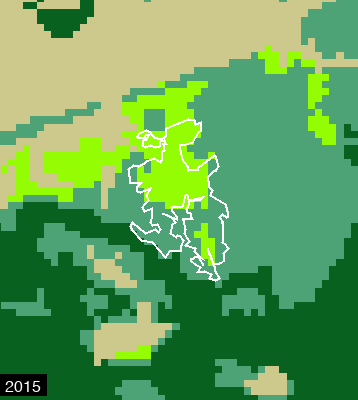

In [20]:
# Render a single year
img = render_site_layer(
    site=site,
    layer=MAPBIOMAS_DEFREG,
    year=2015,
    buffer_m=500,
    dimensions=400,
    show_boundary=True,
    label='2015'
)
img

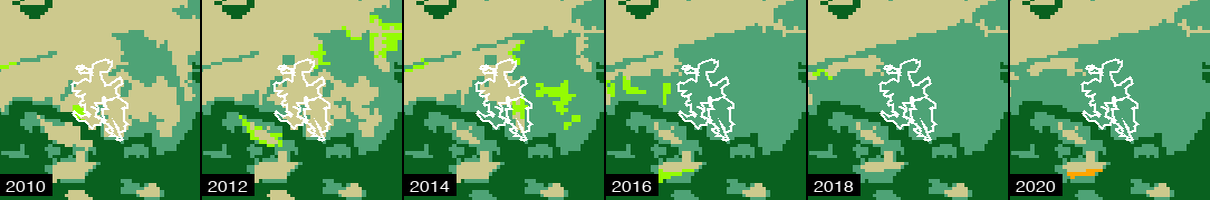

In [22]:
# Create a timestrip showing multiple years
export_timestrip(
    site=site,
    layer=MAPBIOMAS_DEFREG,
    output_path='../outputs/site_9368_timestrip.png',
    years=[2010, 2012, 2014, 2016, 2018, 2020],
    buffer_m=500,
    tile_size=200,
    show_boundary=True
)

# Display the result
from IPython.display import Image as IPImage
IPImage('../outputs/site_9368_timestrip.png')

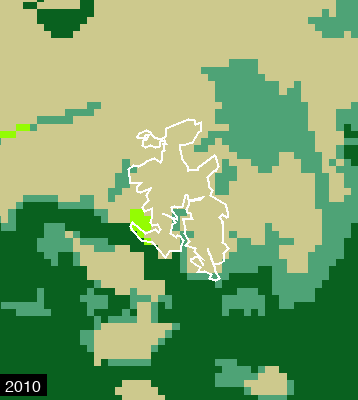

In [23]:
# Create an animated GIF
export_gif(
    site=site,
    layer=MAPBIOMAS_DEFREG,
    output_path='../outputs/site_9368_timelapse.gif',
    years=list(range(2010, 2021)),
    buffer_m=500,
    dimensions=400,
    duration_ms=500
)

# Display the GIF
IPImage('../outputs/site_9368_timelapse.gif')

### Sentinel-2 RGB Imagery

Visualize true-color satellite imagery:

In [36]:
# Load a site
site = sites[0]
print(site)

Site(id=3107, start_year=2016)


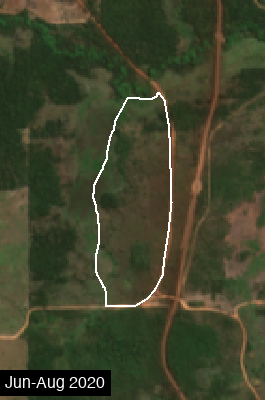

In [37]:
# Render a single Sentinel-2 true-color image
img = render_sentinel_rgb(
    site=site,
    date_range=('2020-06-01', '2020-08-31'),  # Dry season composite
    buffer_m=500,
    dimensions=400,
    show_boundary=True,
    label='Jun-Aug 2020'
)
img

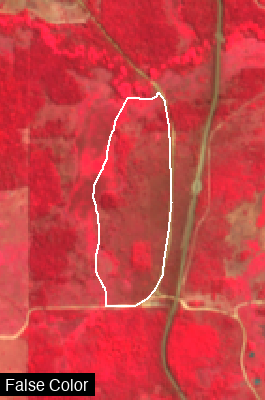

In [38]:
# False color (NIR-Red-Green) - highlights vegetation in red
img_false = render_sentinel_rgb(
    site=site,
    date_range=('2020-06-01', '2020-08-31'),
    bands=SENTINEL_FALSE_COLOR,  # NIR, Red, Green
    buffer_m=500,
    dimensions=400,
    label='False Color'
)
img_false

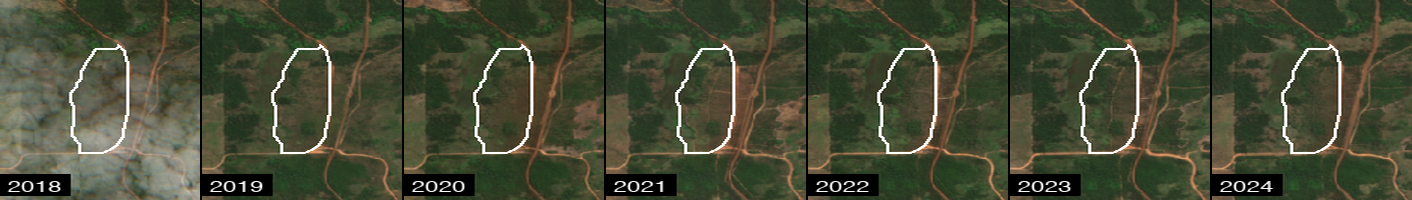

In [40]:
# Create yearly dry-season composites for multiple years
date_ranges = [
    ('2018-06-01', '2018-08-31'),
    ('2019-06-01', '2019-08-31'),
    ('2020-06-01', '2020-08-31'),
    ('2021-06-01', '2021-08-31'),
    ('2022-06-01', '2022-08-31'),
    ('2023-06-01', '2023-08-31'),
    ('2024-06-01', '2024-08-31'),
]
labels = ['2018', '2019', '2020', '2021', '2022', '2023', '2024']

# Timestrip of Sentinel imagery
export_sentinel_timestrip(
    site=site,
    output_path='../outputs/site_9368_sentinel_timestrip.png',
    date_ranges=date_ranges,
    labels=labels,
    buffer_m=500,
    tile_size=200
)

IPImage('../outputs/site_9368_sentinel_timestrip.png')

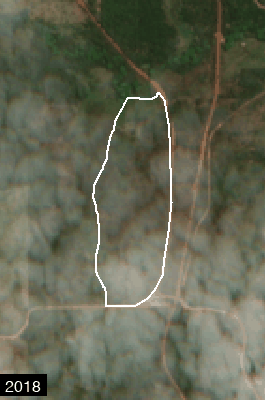

In [41]:
# Animated GIF of Sentinel imagery over years
export_sentinel_gif(
    site=site,
    output_path='../outputs/site_9368_sentinel_timelapse.gif',
    date_ranges=date_ranges,
    labels=labels,
    buffer_m=500,
    dimensions=400,
    duration_ms=800
)

IPImage('../outputs/site_9368_sentinel_timelapse.gif')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()